In this notebook, I will demonstrate how to use existing SDSS software to create a desired commissioning carton and then creat FPS designs from that carton. In this example, I will specifically creating a design that includes spectrophotometric standards, skies and other standards. This example will be a more complex design, so if you need to look at a more straightforward example, please look at the example of creating an all-sky carton.

# Commissioning Carton Creation

If you have a set of targets with known IDs (Gaia, 2MASS, etc), a list of targets for the carton can easily be created from querying catalogdb. For this example though, I will be creating a carton of spectrophotometric standard stars in Gaia eDR3 (https://ui.adsabs.harvard.edu/abs/2021MNRAS.503.3660P/abstract), where the IDs are not currently in catalogdb.

First, I will open Table 1 from the above paper with the standard stars:

In [1]:
import pandas as pd
import numpy as np
from sdssdb.peewee.sdss5db import catalogdb

# connect to catalogdb
catalogdb.database.connect_from_parameters(user='sdss_user',
                                          host='localhost',
                                          port=7500)

True

In [2]:
# load Table 1
stands = pd.read_csv('stab766_supplemental_files/Table1.csv')

In [3]:
stands

,spssId,spssName,gaiaID,RA,Dec,Bmag,Vmag,spType,inV1,inV2,flag,Notes
0,1,G191-B2B,266077145295627520,76.377669,52.830674,11.444,11.792,DA0,yes,yes,0,-
1,2,GD71,3348071631670500736,88.115437,15.886239,12.792,13.032,DA1,yes,yes,0,-
2,3,GD153,3944400490365194368,194.259493,22.030385,13.110,13.399,DA1,yes,yes,0,-
3,5,EG21,4646535078125821568,47.629732,-68.601398,11.403,11.400,DA3,yes,yes,0,-
4,6,GD50,3251244858154433536,57.209484,-0.976360,13.789,14.070,DA2,yes,yes,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...
114,347,HD271759,5476400477145058816,90.172277,-66.053705,11.093,10.873,A2,yes,yes,2,Warning spectral defects (>3%)
115,348,HD271783,5284204302730217984,90.547608,-66.583021,12.539,11.955,F5,yes,yes,2,Warning spectral defects (>3%)
116,349,HIP28618,5284151216932205312,90.616156,-66.791283,12.143,12.282,B8,yes,no,-1,Non photometric - spectral defects
117,350,LTT377,5006921282807193856,10.375121,-33.626680,11.970,10.530,K9,yes,yes,1,Warning minor spectral defects (<3%)


Next, I will do a cone search in catalogdb to match the DR2 objects to eDR3. For example, I will just assume the best match is the one with the smallest angular separation.

In [4]:
#create column for DR2 IDs
stands['gaiaID_DR2'] = 9999

# radius used for cone search
r = 3/3600
for i in range(len(stands)):
    # query catalogdb around ith standard
    stand_dr2 = (catalogdb.Gaia_DR2.select(catalogdb.Gaia_DR2.ra,
                                           catalogdb.Gaia_DR2.dec,
                                           catalogdb.Gaia_DR2.source_id)
                                    .where(catalogdb.Gaia_DR2.cone_search(stands.loc[i, 'RA'],
                                                                          stands.loc[i, 'Dec'],
                                                                          r)))
    # get the ras, decs and DR2 IDs for the query
    ras, decs, dr2_ids = map(list, zip(*list(stand_dr2.tuples())))
    ras = np.array(ras)
    decs = np.array(decs)
    # calculate seperations
    seps = np.sqrt((3600 * (ras - stands.loc[i, 'RA']) * np.cos(stands.loc[i, 'Dec'] / 57.296)) ** 2 +
                   (3600 * (decs - stands.loc[i, 'Dec'])) ** 2)
    # set best match as DR2 object with minimum seperation
    stands.loc[i, 'gaiaID_DR2'] = dr2_ids[np.argmin(seps)]

Now, similar to our most common example, we have a list of known IDs that we can use to pull the relevtant information to form our carton. At this point, we will need the catalogids, RAs and DECs of the object in catalogdb. 

It will be important here to specify the version of catalogdb we will be using. You can see the catalogdb versions by:

In [5]:
ver = catalogdb.Version.select()

for v in ver:
    print(v.id, v.plan, v.tag)

21 0.1.0 0.1.0
3 0.1.0-alpha.1 0.1.0-alpha.1
16 0.1.0-alpha.5 0.1.0-beta.2
17 0.1.0-alpha.6 0.1.0-beta.3
23 0.5.0-beta.1 0.2.0b0
24 0.5.0-beta.2 0.2.0b1
999 test test
9 0.1.0-alpha.2 0.1.0-alpha.2
10 0.1.0-alpha.3 0.1.0-alpha.3
18 0.1.0-alpha.7 0.1.0-beta.3
11 0.1.0-alpha.4 0.1.0-alpha.4
25 0.5.0 0.2.2
13 0.1.0-beta.1 0.1.0b3


For this, we will be using the most up-to-date of catalogdb version 0.5.0:

In [6]:
# query catalogdb for Gaia DR2 objects in our list of standards in catalogdb version 0.5.0
stands_cdb = (catalogdb.Gaia_DR2.select(catalogdb.Gaia_DR2.ra,
                                        catalogdb.Gaia_DR2.dec,
                                        catalogdb.Gaia_DR2.source_id,
                                        catalogdb.Catalog.catalogid)
                                .join(catalogdb.TIC_v8)
                                .join(catalogdb.CatalogToTIC_v8)
                                .join(catalogdb.Catalog)
                                .join(catalogdb.Version)
                                .where((catalogdb.Gaia_DR2.source_id.in_(stands['gaiaID_DR2'].tolist())) &
                                       (catalogdb.Version.id == 25)))

# get result
ras, decs, dr2_ids, catalogids = map(list, zip(*list(stands_cdb.tuples())))

Now we can create a .fits file that will serve as our carton. This .fits file can be used by the target selection code to add this commissioning carton to targetdb. The .fits will need to have the following columns, where you just need to change the array input to what will be used for this specific carton.

In [7]:
from astropy.io import fits

# number of rows in table for creating new blank columns
nrows = len(catalogids)

# create all columns

# Gaia DR2 IDs for targets
col1 = fits.Column(name='Gaia_DR2_Source_ID',
                   format='K',
                   array=dr2_ids,
                   null=-9999)

# If no Gaia counterpart, add Legacy Survey ID
col2 = fits.Column(name='LegacySurvey_DR8_ID',
                   format='K',
                   array=[-9999] * nrows,
                   null=-9999)

# right ascension of the targets
col3 = fits.Column(name='ra',
                   format='D',
                   array=ras)

# declination of the targets
col4 = fits.Column(name='dec',
                   format='D',
                   array=decs)

# specify if fiber should be offset from target position (in arcseconds)
col5 = fits.Column(name='delta_ra',
                   format='D',
                   array=[0.] * nrows)

# specify if fiber should be offset from target position (in arcseconds)
col6 = fits.Column(name='delta_dec',
                   format='D',
                   array=[0.] * nrows)

# indicate if proper motions should be ignored (=0 ignored, =1 applied)
col7 = fits.Column(name='inertial',
                   format='J',
                   array=[1] * nrows)

# specify the priority of each target
col8 = fits.Column(name='priority',
                   format='J',
                   array=[6080] * nrows)

# add the cadence for the observation, from list of cadences: https://wiki.sdss.org/display/OPS/Cadence+Alignment
col9 = fits.Column(name='cadence',
                   format='20A',
                   array=['bright_1x1'] * nrows)

# specify the instrument for observations
col10 = fits.Column(name='instrument',
                    format='20A',
                    array=['BOSS'] * nrows)

# add the name you want to use for the carton
col11 = fits.Column(name='cartonname',
                    format='20A',
                    array=['comm_spectrophoto'] * nrows)

# create column definitions for all columns
cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11])

# create the table HDU
hdu = fits.BinTableHDU.from_columns(cols)

# write table to .fits file
# This name will need to remain constant after this, with only the version being updated
# if adjustments need to be made to the Carton
hdu.writeto('Commissioning_SpectrophotoStandards_v0.0.0.fits', overwrite=True)

We can also quickly see the sky coverage of our new carton to see what we will be working with when creating a future design.

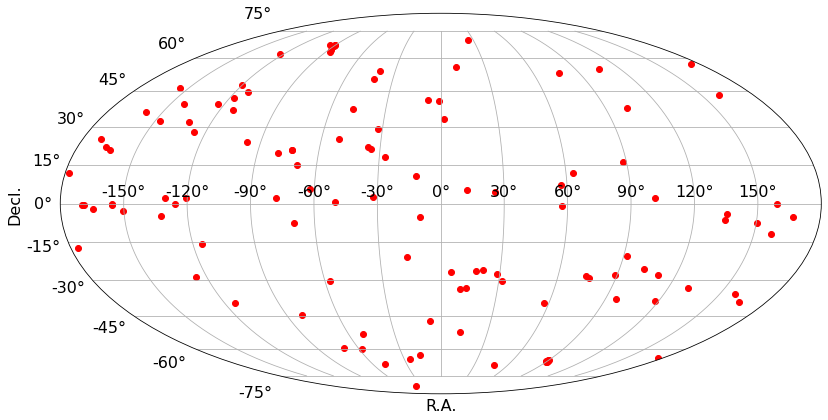

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='mollweide')

ra = np.radians(hdu.data['ra'])
dec = np.radians(hdu.data['dec'])

ra[ra > np.pi] = ra[ra > np.pi] - 2 * np.pi

ax.scatter(ra, dec, c='r')
ax.grid()
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
plt.show()